# Imports

In [1]:
%load_ext autoreload
%load_ext Cython
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
from util import *
%aimport mc.util 
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['CC'] = 'clang'
os.environ['CXX'] = 'clang -shared'

In [9]:
%%cython -f
import numpy as np
import cython

def center_mono(c: tuple[cython.int, cython.int], pos: tuple[cython.int, cython.int], w: cython.int, h: cython.int) -> tuple[cython.int, cython.int]:
    xpos: cython.int = (pos[0]-c[0]+w//2)%w - w//2
    ypos: cython.int = (pos[1]-c[1]+h//2)%h - h//2
    return (xpos, ypos)

def read_trimers_line(f, l, stride=1):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0:
                pos = []
                for entry in l[:-1].split(" "):
                    if entry == "": continue
                    tokens = entry[1:-1].split(",")
                    pos.append((int(tokens[0]), int(tokens[1]), int(tokens[2])))
                yield pos

def read_monomers_line(f, l, stride=1, skip=0):
    with open(f, "r") as f:
        for index, l in enumerate(f):
            if index % stride == 0 and index >= skip:
                yield [[int(i) for i in x[1:-1].split(",")] for x in l[:-1].split(" ") if x != ""]

def read_monomers_cut(f, l, stride=1):
    import collections
    vals = collections.defaultdict(lambda: 0)
    for pos in read_monomers_line(f, l, stride):
        for i in range(len(pos)):
            for j in range(len(pos)):
                dp: tuple[cython.int, cython.int] = (pos[i][0]-pos[j][0], pos[i][1]-pos[j][1])
                orig: tuple[cython.int, cython.int] = (0, 0)
                d = center_mono(orig, dp, l, l)
                if d[0] == 0:
                    vals[d[1]] += 1
    return vals

$$\langle \rho(0) \rho(d) \rangle = P(\rho(0) = 1 \cap \rho(d) = 1)$$
$$= P(\rho(d) = 1 | \rho(0) = 1) P(\rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$
$$= \frac{n}{L^2} P(\rho(d) = 1 | \rho(0) = 1)$$

$$Count(d) = n^2 N P(\rho(d) = 1 | \rho(0) = 1)$$
$$\langle \rho(0) \rho(d) \rangle = \frac{1}{nNL^2} Count(d)$$

# 0K

## Monomer-Dimer correlation

In [ ]:
n = 42
vals = np.zeros((n, n))
for l in read_mono_di_line("data/42x42-3-10000000-mono-di.dat", n):
    for g in l:
        vals[g[0], g[1]] += 1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_aspect("equal")
ax.plot([0, 1], [0, 0], color="w", lw=4)

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=0, vmax=np.max(vals))
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(vals[(i+n//2)%n - n//2, (j+n//2)%n-n//2])))

ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-dimer correlation L=42 filling=-1")

In [ ]:
n = 42
vals = np.zeros((n, n))
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", n):
    for g in l:
        vals[g[0], g[1]] += 1

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=[10, 6])
ax.axis("off")
ax.set_xlim([-20, 20])
ax.set_ylim([-20, 20])
ax.set_aspect("equal")
ax.plot([0, 1], [0, 0], color="w", lw=4)

import matplotlib
patches = []
colors = []
N = matplotlib.colors.Normalize(vmin=0, vmax=np.max(vals))
for i in range(-n//2, n//2):
    for j in range(-n//2, n//2):
        patches.append(matplotlib.patches.Circle((i+j/2, j*np.sqrt(3)/2), radius=0.5))
        colors.append(matplotlib.colormaps["viridis"](N(vals[(i+n//2)%n - n//2, (j+n//2)%n-n//2])))

ax.add_collection(matplotlib.collections.PatchCollection(patches, facecolors=colors))
fig.colorbar(matplotlib.cm.ScalarMappable(norm=N, cmap="viridis"), ax=ax)
plt.title("monomer-dimer correlation L=42 filling=-2")

In [ ]:
p1, p2, p3 = [], [], []
for l in read_mono_di_line("data/42x42-6-10000000-mono-di.dat", 42):
    v1, v2, v3 = 0, 0, 0
    for g in l:
        g = tuple(g)
        if g == (1, 2):
            v1 += 1
        elif g == (10, 0):
            v2 += 1
        elif g == (10, 10):
            v3 += 1
    p1.append(v1)
    p2.append(v2)
    p3.append(v3)

In [ ]:
autocorr(p1, "r=(1, 2)")
autocorr(p2, "r=(10, 0)")
autocorr(p3, "r=(10, 10)")
plt.title("autocorr monomer-dimer L=42 n=-2")
plt.xscale("log")
plt.ylim([0, 20])
plt.legend()

In [ ]:
xs = np.arange(len(p1)//100000) * 100000
plt.plot(xs, bin(np.array(p1), 100000), label="r=(1, 2)")
plt.plot(xs, bin(np.array(p2), 100000), label="r=(10, 0)")
plt.plot(xs, bin(np.array(p3), 100000), label="r=(10, 10)")
plt.title("Equilibration monomer-dimer")
plt.legend()

## Tilings

In [ ]:
pos = list(read_trimers_line("data/96x96-3-1000000.1000-trimers.dat", 96))
# pos = list(read_trimers_line("data/96x96-3-1000-trimers.dat", 96))

In [ ]:
def topo_sectors(pos, lines, l):
    mpos = set(pos)
    vals = []
    for start, dir in lines:
        cpos = start
        total = 0
        while True:
            if cpos in mpos:
                total += 1

            if dir == 0:
                if cpos[2] == 0:
                    cpos = (cpos[0] - 1, cpos[1] + 1, 1)
                else:
                    cpos = (cpos[0], cpos[1] + 1, 0)
            elif dir == 1:
                if cpos[2] == 0:
                    cpos = (cpos[0], cpos[1], 1)
                else:
                    cpos = (cpos[0] + 1, cpos[1] + 1, 0)
            elif dir == 2:
                if cpos[2] == 0:
                    cpos = (cpos[0] + 1, cpos[1] - 1, 1)
                else:
                    cpos = (cpos[0] + 1, cpos[1], 0)

            cpos = (cpos[0] % l, cpos[1] % l, cpos[2])

            if cpos == start:
                break
        vals.append(total)
    return vals

In [ ]:
fig, ax = plt.subplots(2, 1)

x1, x2, x3, x4 = [], [], [], []
for i in range(1000):
    x1.append(topo_sectors(pos[i], [((0, 0, 0), 0)], 96)[0])
    x2.append(topo_sectors(pos[i], [((1, 0, 0), 0)], 96)[0])
    x3.append(topo_sectors(pos[i], [((0, 0, 0), 1)], 96)[0])
    x4.append(topo_sectors(pos[i], [((1, 0, 0), 1)], 96)[0])

ax[0].plot(x1[:400], label="R1")
ax[0].plot(x2[:400], label="B1")
ax[0].plot(x3[:400], label="R2")
ax[0].plot(x4[:400], label="B2")
ax[1].set_ylabel("Quantum numbers")
ax[0].legend()

d1 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 47)
d2 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 45)
d3 = read_trimers_r("data/96x96-3-1000000.1000-trimers-cut.dat", 96, 20)
ax[1].set_ylabel("Trimer-trimer correlation")
ax[1].plot(d1[:400], label="r=47")
ax[1].plot(d2[:400], label="r=45")
ax[1].plot(d3[:400], label="r=20")
ax[1].set_xlabel("Time (x1000)")
ax[1].legend()

In [ ]:
plt.plot([topo_sectors(pos[i], [((0, 0, 0), 0)], 96)[0]
          + topo_sectors(pos[i], [((1, 0, 0), 0)], 96)[0]
          + topo_sectors(pos[i], [((2, 0, 0), 0)], 96)[0] for i in range(1000)])

## Trimer-Trimer correlation

## Trimers

In [ ]:
data1 = read_accumulator("data/t0j0/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((96, 96, 2))
data2 = read_accumulator("data/t0j0/-1/84x84_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((84, 84, 2))
data3 = read_accumulator("data/t0j0/-1/72x72_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((72, 72, 2))
data4 = read_accumulator("data/t0j0/-1/60x60_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((60, 60, 2))
data5 = read_accumulator("data/t0j0/-1/48x48_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data6 = read_accumulator("data/t0j0/-1/24x24_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((24, 24, 2))
data7 = read_accumulator("data/t0j0/-1/12x12_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((12, 12, 2))
data8 = read_accumulator("data/t0j0/-1/6x6_r-3_t0.000000_j0.000_50000000.20_0/tri-tri.dat", skip=10)[0].reshape((6, 6, 2))

/tmp/ipykernel_4089479/3084718470.py:31: RuntimeWarning: divide by zero encountered in power
  return B * np.power(np.abs(x), A) + C


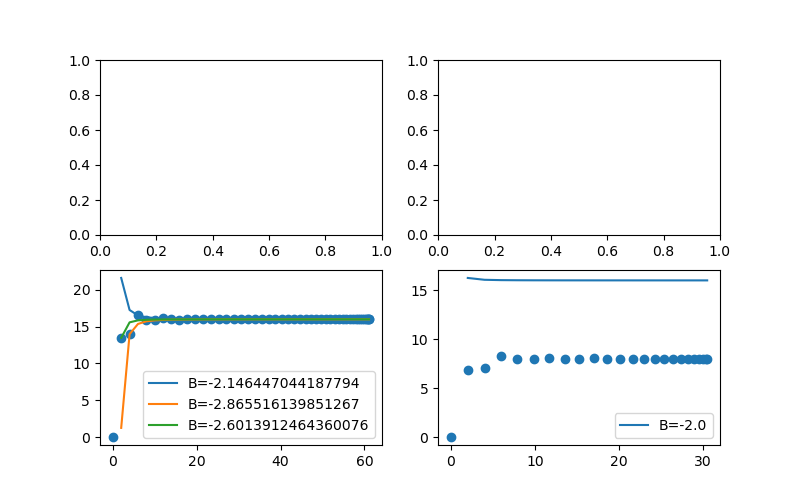

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[8, 5])
# plot2d_hex(ax[0, 0], data1)
# plot2d_hex(ax[0, 1], data2)

def mod(data, x, y, s):
    return data.transpose(1, 0, 2)[x%(data.shape[0]), y%(data.shape[1]), s]

def symmetrize(data, sublattice=0):
    lin = [0]
    xs = np.arange(data.shape[0]//2) * 2
    for i in range(1, data.shape[0]//2):
        total = 0
        total += mod(data, i, i, 0)
        total += mod(data, -i, 2*i, 0)
        total += mod(data, -2*i, i, 0)
        total += mod(data, -i, -i, 0)
        total += mod(data, i, -2*i, 0)
        total += mod(data, 2*i, -i, 0)
        lin.append(total / 6)

    lin = np.array(lin)

    L = data.shape[0] * 2
    xs = np.sin(np.pi/L * xs) / (np.pi/L)
    return xs, lin

def fit(xs, ys):
    import scipy

    def fun(x, A, B, C):
        return B * np.power(np.abs(x), A) + C
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-2, 1, 16])

    return fun, param

x1, y1 = symmetrize(data1)
ax[1, 0].scatter(x1, y1)
fun, param = fit(x1[3::3], y1[3::3])
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
fun, param = fit(x1[2::3], y1[2::3])
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
fun, param = fit(x1[1::3], y1[1::3])
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
ax[1, 0].legend()

x2, y2 = symmetrize(data2)
ax[1, 1].scatter(x2, y2)
fun, param = fit(x2, y2)
ax[1, 1].plot(x2, fun(x2, *param), label=f"B={param[0]}")
ax[1, 1].legend()

{(248832, 0, 0): [1, 16.00613142857141], (245388, 0, 1): [1, 16.023475102040837], (243684, 0, 0): [2, 31.96156448979592], (240276, 0, 1): [2, 31.94809020408163], (238608, 0, 0): [2, 31.966841224489798], (235236, 0, 1): [2, 31.94801551020408], (233604, 0, 0): [2, 32.02073632653064], (230268, 0, 1): [2, 32.03354204081631], (228672, 0, 0): [2, 31.95848163265306], (225372, 0, 1): [2, 31.951715102040815], (223812, 0, 0): [2, 31.963691836734696], (220548, 0, 1): [2, 31.951769795918366], (219024, 0, 0): [2, 32.02299510204077], (215796, 0, 1): [2, 32.03097224489799], (214308, 0, 0): [2, 31.96324612244898], (211116, 0, 1): [2, 31.948272653061224], (209664, 0, 0): [2, 31.96436775510204], (206508, 0, 1): [2, 31.96907142857143], (205092, 0, 0): [2, 32.01512938775512], (201972, 0, 1): [2, 32.02207714285714], (200592, 0, 0): [2, 31.95942489795918], (197508, 0, 1): [2, 31.952217142857144], (196164, 0, 0): [2, 31.960005306122447], (193116, 0, 1): [2, 31.964305714285715], (191808, 0, 0): [2, 32.0146632

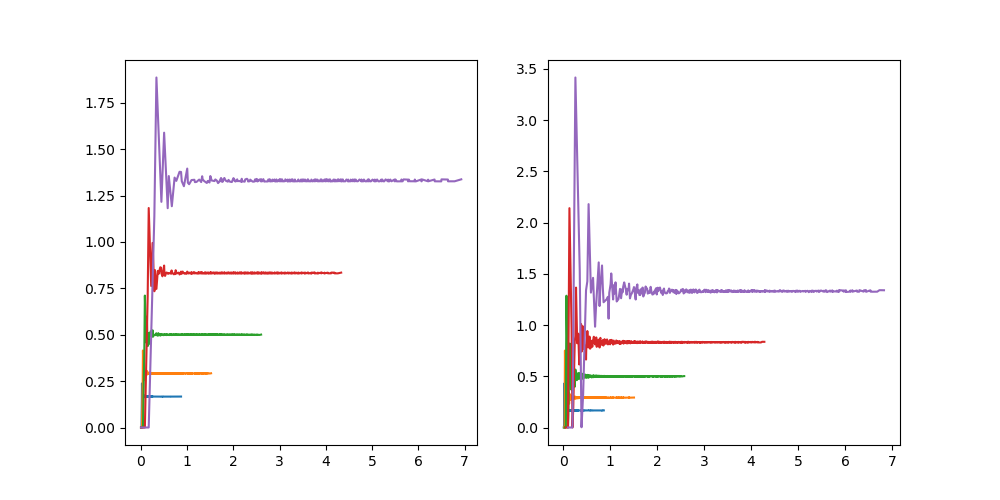

In [ ]:
def symmetrize2(data):
    vals = {}
    def add(x, y, s):
        if s == 1:
            xy = ((6*x + 3*y + 3, 0), (0, 3*y + 1))
        else:
            xy = ((6*x + 3*y, 0), (0, 3*y))
        dist = (xy[0][0]**2 + 3*xy[0][1]**2 + xy[1][0]**2 + 3*xy[1][1]**2,
                2*xy[0][0]*xy[0][1] + 2*xy[1][0]*xy[1][1], s)

        if dist not in vals:
            vals[dist] = [0, 0]
        vals[dist][0] += 1
        vals[dist][1] += mod(data, x, y, s)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            add(i - data.shape[0]//2, j - data.shape[1]//2, 0)
            add(i - data.shape[0]//2, j - data.shape[1]//2, 1)
    
    print(vals)
    xs0 = []
    ys0 = []
    xs1 = []
    ys1 = []
    for key, val in sorted(vals.items(), key=lambda x: x[0][0] + x[0][1] * np.sqrt(3)):
        if key[2] == 0:
            xs0.append(np.sqrt((key[0] + key[1] * np.sqrt(3))/36))
            ys0.append(val[1] / val[0])
        else:
            xs1.append(np.sqrt((key[0] + key[1] * np.sqrt(3))/36))
            ys1.append(val[1] / val[0])
    return tuple(map(np.array, [xs0, ys0, xs1, ys1]))

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
def do(data, scale):
    x, y, xb, yb = symmetrize2(data)
    ax[0].plot(x / scale, y / scale)
    ax[1].plot(xb / scale, yb / scale)
do(data1, 96)
do(data2, 48)
do(data3, 24)
do(data4, 12)
do(data5, 6)

In [ ]:
# x = read_trimers_cut("data/72x72-6-1000000-trimers-cut.dat", 72, stride=1, skip=500000)
x1 = read_trimers_cut("data/96x96-3-2000000-trimers-cut.dat", 96, stride=1, skip=800000)
# x2 = read_trimers_cut("data/108x108-3-5000000-trimers-cut.dat", 108, skip=2500000, stride=10)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=[8, 5])

xr = x1 / x1.sum()
xs = np.arange(x1.shape[0])

import scipy

def fit(x, A, B, C):
    return B * np.power(x, A) + C

def fitplot(x, y, ax):
    P, cov = scipy.optimize.curve_fit(fit, x, y, p0=[-2, 1, 0.1])
    y0 = P[2]
    print(y0)
    ax.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P)-y0, label=f"{P[0]:.2f}+-{np.sqrt(cov[0, 0]):.2f}")
    ax.scatter(x, y-y0)
    ax.legend()

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("y-y0")
    ax.set_xlabel("x")
    ax.set_title(f"y0={y0:.5f}")

fitplot(xs[1::3], xr[1::3], ax[0, 0])
fitplot(xs[2::3], xr[2::3], ax[0, 1])
fitplot(xs[3::3], -xr[3::3], ax[0, 2])

def fit(x, A, B):
    return B * np.power(x, A)

p0 = (xr[-10:].max() + xr[-10:].min())/2


def fitplot(x, y, ax):
    P, cov = scipy.optimize.curve_fit(fit, x, y, p0=[-2, 1])
    ax.plot(np.linspace(2, xr.shape[0], 100), fit(np.linspace(2, xr.shape[0], 100), *P), label=f"{P[0]:.2f}+-{np.sqrt(cov[0, 0]):.2f}")
    ax.scatter(x, y)
    ax.legend()

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("y-y0")
    ax.set_xlabel("x")
    ax.set_title(f"y0={p0:.5f}")

print(p0)
fitplot(xs[1::3], xr[1::3]-p0, ax[1, 0])
fitplot(xs[2::3], xr[2::3]-p0, ax[1, 1])
fitplot(xs[3::3], -xr[3::3]+p0, ax[1, 2])

plt.suptitle("Trimer-trimer correlation L=96 filling=-1")
plt.tight_layout()

In [ ]:
d1 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 2, skip=0, stride=1)
d2 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 20, skip=0, stride=1)
d3 = read_trimers_r("data/108x108-3-5000000-trimers-cut.dat", 108, 50, skip=0, stride=1)

In [ ]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=20")
autocorr(d3[skip:], "r=50")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=108 n=-1 skip=1M")

In [ ]:
d1 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-3-2000000-trimers-cut2.dat", 60, 25, skip=0, stride=1)

In [ ]:
skip = 1000000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-1 skip=1M")

In [ ]:
d1 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 2, skip=0, stride=1)
d2 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 10, skip=0, stride=1)
d3 = read_trimers_r("data/60x60-6-1000000-trimers-cut.dat", 60, 25, skip=0, stride=1)

In [ ]:
skip = 500000
autocorr(d1[skip:], "r=2")
autocorr(d2[skip:], "r=10")
autocorr(d3[skip:], "r=25")
plt.legend()
plt.xscale("log")
plt.title("autocorr trimer-trimer L=60 n=-2 skip=0.5M")

## Monomer-Monomer

### Correlation

$$\overline{x}=\sin(\pi x/L)/(\pi/L)$$

In [ ]:
i = 60
L = i
d = read_monomers_cut(f"data/{i}x{i}-3-3000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>0, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))

plt.legend()
plt.title("monomer-monomer L=48 filling=-1")
plt.ylabel("counts (au)")
plt.xlabel("r (transformed)")

In [ ]:
i = 96
L = i
d = read_monomers_cut(f"data/0K/{i}x{i}-3-50000000.10-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

Text(0.5, 0, '$\\overline{x}$')

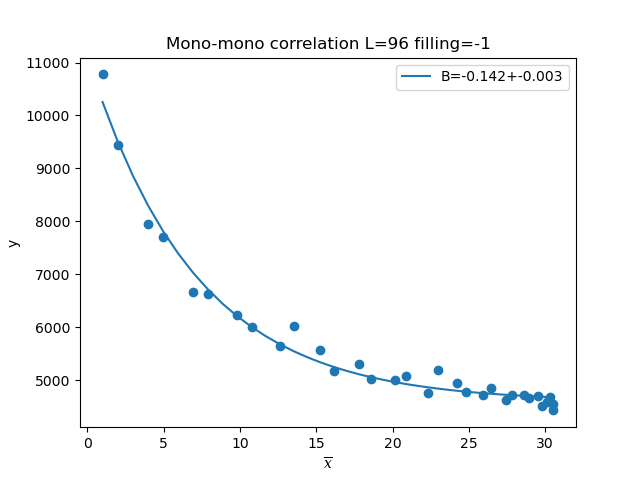

In [29]:
import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)
def fit(x, A, B, C):
    return B * np.exp(np.abs(x) * A) + C

# plt.scatter(dk[L//2:], dn[L//2:])
sigma = np.sqrt(dn/5e6*(1-dn/5e6)*5e6)

crit = np.logical_and(dn>0, dk>0)

plt.figure()
plt.scatter(dk[crit], dn[crit])

# P, cov = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 1000], sigma=sigma[crit], absolute_sigma=True)
P, cov = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.13, 10000, 5000], sigma=sigma[crit], absolute_sigma=True)

plt.plot(dk[L//2:], fit(dk[L//2:], *P), label=f"B={P[0]:.3f}+-{np.sqrt(cov[0,0]):.3f}")

plt.legend()
plt.title(f"Mono-mono correlation L={L} filling=-1")
plt.ylabel("y")
plt.xlabel("$\\overline{x}$")

In [ ]:
i = 48
L = i
d = read_monomers_cut(f"data/{i}x{i}-6-1000000-monomers.dat", i)
dn = np.zeros((max(d.keys())-min(d.keys()) + 1,))
dk = np.arange(min(d.keys()), max(d.keys()) + 1)
for key, value in sorted(d.items()):
    dn[key-min(d.keys())] = value

dn[len(dn)//2] = 0
dk = np.sin(np.pi/L * dk) / (np.pi/L)

import scipy
def fit(x, A, B):
    return B * np.power(np.abs(x), A)

crit = np.logical_and(dn>12000, dk>0)
P, _ = scipy.optimize.curve_fit(fit, dk[crit], dn[crit], p0=[-0.25, 10])

plt.plot(dk, dn)
plt.plot(dk, fit(dk, *P), label=str(P[0]))
plt.legend()
plt.title("monomer-monomer L=48 filling=-2")

In [ ]:
p1 = read_monomers_r(f"data/96x96-3-50000000-monomers.dat", 96, [(0, 1), (0, 10), (0, 25), (31, 30)])

In [ ]:
skip = 500000
autocorr(p1[(0, 1)][skip:], "r=(0, 1)")
autocorr(p1[(0, 10)][skip:], "r=(0, 10)")
autocorr(p1[(0, 25)][skip:], "r=(0, 25)")
autocorr(p1[(31, 30)][skip:], "r=(31, 30)")
plt.legend()
plt.xscale("log")
plt.title("autocorr mono-mono L=60 n=-1 skip=0.5M")

In [ ]:
n = 30000
rng = np.arange(len(p1[(0, 1)])//n) * n
plt.plot(rng, bin(p1[(0, 1)], n))
plt.plot(rng, bin(p1[(0, 10)], n))
plt.plot(rng, bin(p1[(0, 25)], n))
plt.plot(rng, bin(p1[(24, 25)], n))
plt.title("equilib mono-mono L=60 n=-1")

### 2D correlation

In [ ]:
d1 = read_monomers(f"data/0K/6x6-3-50000000.10-monomers.dat", 6)
d2 = read_monomers(f"data/0K/12x12-3-50000000.10-monomers.dat", 12)
d3 = read_monomers(f"data/0K/24x24-3-50000000.10-monomers.dat", 24)
d4 = read_monomers(f"data/0K/48x48-3-50000000.10-monomers.dat", 48)
d5 = read_monomers(f"data/0K/96x96-3-50000000.10-monomers.dat", 96)

In [ ]:
plt.figure()
plot2d(d1, 6)
plt.figure()
plot2d(d2, 12)
plt.figure()
plot2d(d3, 24)
plt.figure()
plot2d(d4, 48)
plt.figure()
plot2d(d5, 96)

# T>0

In [38]:
# for (int i = 1; i < h / 2; i++)
# 		{
# 			if (phase_conf[i - 1] == phase_conf[0])
# 				phase_conf.push_back((rng() % 2) ? (phase_conf[0] + 1) % 3 : (phase_conf[0] + 2) % 3);
# 			else
# 			{
# 				int n = h / 2 - i;
# 				int sign = (n % 2 == 0) ? 1 : -1;
# 				double p_return = (std::pow(2, n - 1) - 2 * sign) / (std::pow(2, n) - sign);

# 				phase_conf.push_back(uniform(rng) <= p_return ? phase_conf[0] : 3 - phase_conf[0] - phase_conf[i - 1]);
# 			}
# 		}


def gen_conf(N):
	conf = [0]
	for i in range(1, N):
		if conf[-1] == 0:
			if np.random.randint(0, 2) == 0:
				conf.append(1)
			else:
				conf.append(2)
		else:
			n = N - i
			sign = 1 if n % 2 == 0 else -1
			p_return = (np.power(2, n-1) - 2*sign) / (np.power(2, n) - sign)
			if np.random.random() < p_return:
				conf.append(0)
			else:
				conf.append(3 - conf[-1])
	return conf

In [51]:
ns = np.arange(4, 30)
xs = []
for n in ns:
    total = 0
    for i in range(1000):
        counts = np.array([0., 0, 0])
        for x in gen_conf(n):
            counts[x] += 1
        counts /= n
        import scipy
        total += scipy.stats.entropy(counts)
    xs.append(total / 1000)

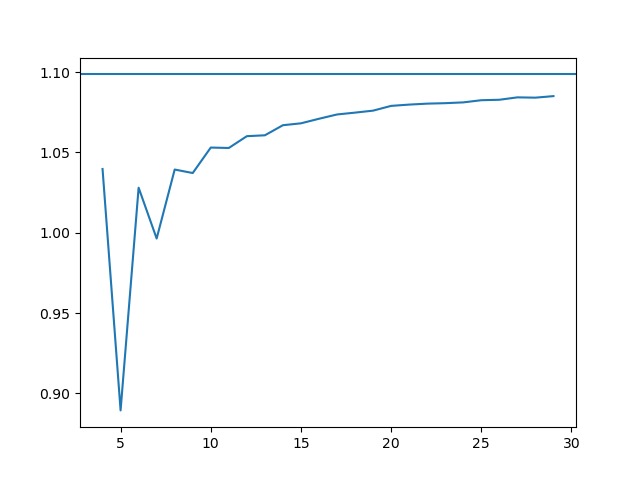

In [52]:
plt.figure()
plt.plot(ns, xs)
plt.axhline(np.log(3))


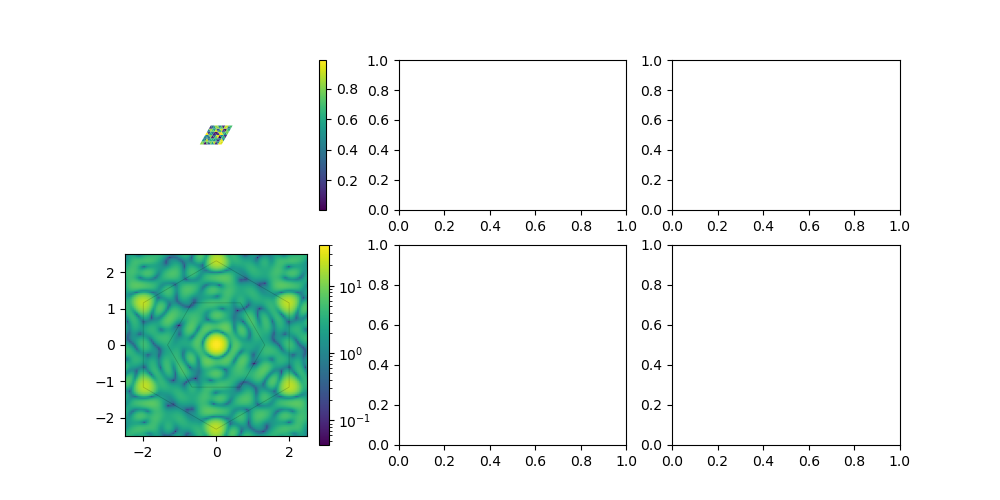

In [57]:
data1 = np.random.random((6, 6, 2))
fig, ax = plt.subplots(2, 3, figsize=[10, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
# plot2d_hex(ax[0,1], data2)
# plot2d_hex(ax[0,2], data3)
plot_FT(ax[1,0], FT_hex2(data1), proj="logabs", fold=False)
# plot_FT(ax[1,1], FT_hex(data2), proj="logabs", fold=False)
# plot_FT(ax[1,2], FT_hex(data3), proj="logabs", fold=False)

## J4/U=0.1

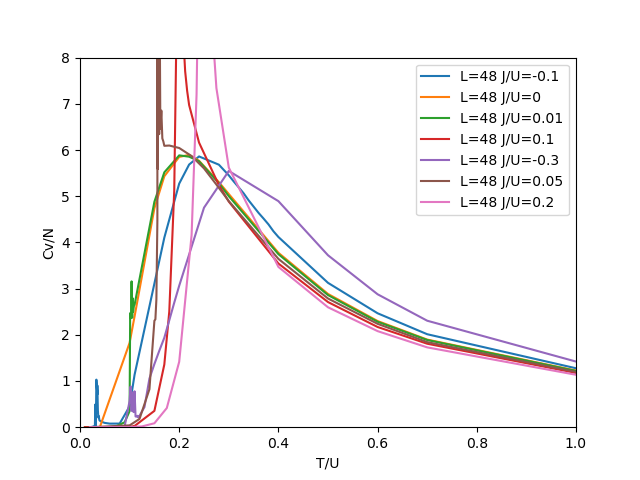

In [8]:
skip = 0
ts0, ds0 = get_all_cvs("data/vsweeps/-0.1/*/energy.dat", skip=skip)
ts1, ds1 = get_all_cvs("data/vsweeps/0/*/energy.dat", skip=skip)
ts2, ds2 = get_all_cvs("data/vsweeps/0.01/*/energy.dat", skip=skip)
ts3, ds3 = get_all_cvs("data/vsweeps/0.1/*/energy.dat", skip=skip)

ts4, ds4 = get_all_cvs("data/vsweeps/-0.3/*/energy.dat", skip=skip)
ts5, ds5 = get_all_cvs("data/vsweeps/0.05/*/energy.dat", skip=skip)
ts6, ds6 = get_all_cvs("data/vsweeps/0.2/*/energy.dat", skip=skip)

plt.close("all")
plt.figure()
plt.plot(ts0, ds0, label="L=48 J/U=-0.1")
plt.plot(ts1, ds1, label="L=48 J/U=0")
plt.plot(ts2, ds2, label="L=48 J/U=0.01")
plt.plot(ts3, ds3, label="L=48 J/U=0.1")
plt.plot(ts4, ds4, label="L=48 J/U=-0.3")
plt.plot(ts5, ds5, label="L=48 J/U=0.05")
plt.plot(ts6, ds6, label="L=48 J/U=0.2")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.xlim([0, 1])
plt.ylim([0, 8])
plt.legend()

Text(0.5, 1.0, 'L=48 J=0.01')

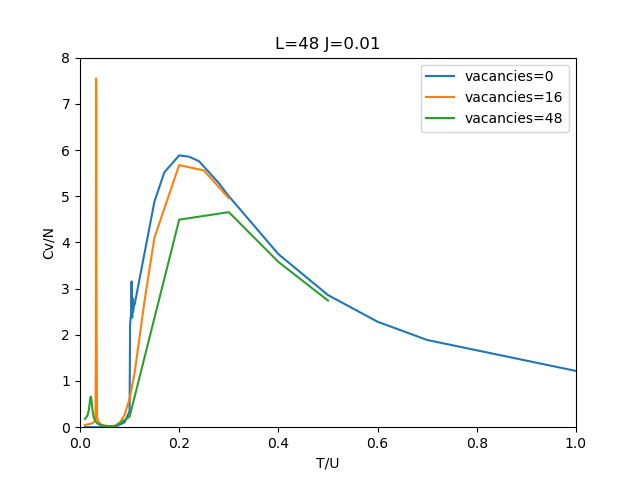

In [15]:
ts1, ds1 = get_all_cvs("data/vsweeps/0.01/*_0/energy.dat")
ts2, ds2 = get_all_cvs("data/vsweeps/v48/0.01/*_0/energy.dat", skip=10)
ts3, ds3 = get_all_cvs("data/vsweeps/v144/0.01/*_0/energy.dat")

# ds2[[11, 12, 14, 15, 17, 18]] *= 4
# ds2[[11, 12, 14, 15, 17, 18]] *= 2

plt.close("all")
plt.figure()
plt.plot(ts1, ds1, label="vacancies=0")
plt.plot(ts2, ds2, label="vacancies=16")
plt.plot(ts3, ds3, label="vacancies=48")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.xlim([0, 1])
plt.ylim([0, 8])
plt.legend()
plt.title("L=48 J=0.01")

Text(0.5, 1.0, 'Comparison of MC algorithms J=0 L=48')

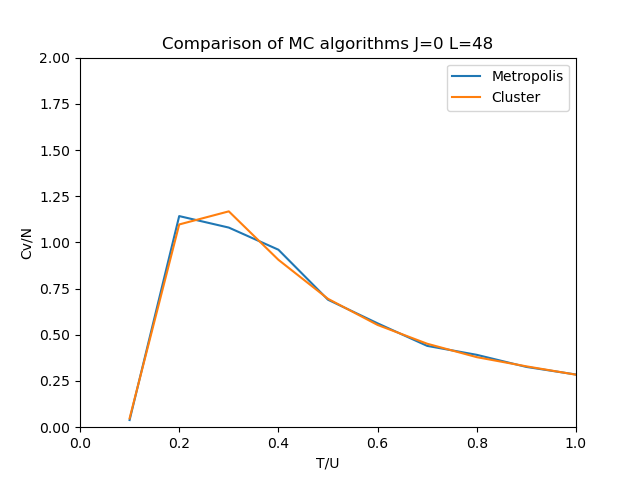

In [18]:
skip=5
ts1, ds1 = get_all_cvs("data/compare/metro/*/energy.dat", skip=skip)
ts2, ds2 = get_all_cvs("data/compare/pocket/*/energy.dat", skip=skip)

plt.close("all")
plt.figure()
plt.plot(ts1, ds1, label="Metropolis")
plt.plot(ts2, ds2, label="Cluster")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.xlim([0, 1])
plt.ylim([0, 2])
plt.legend()
plt.title("Comparison of MC algorithms J=0 L=48")

Text(0.5, 1.0, 'Comparison of MC algorithms J=0 L=48')

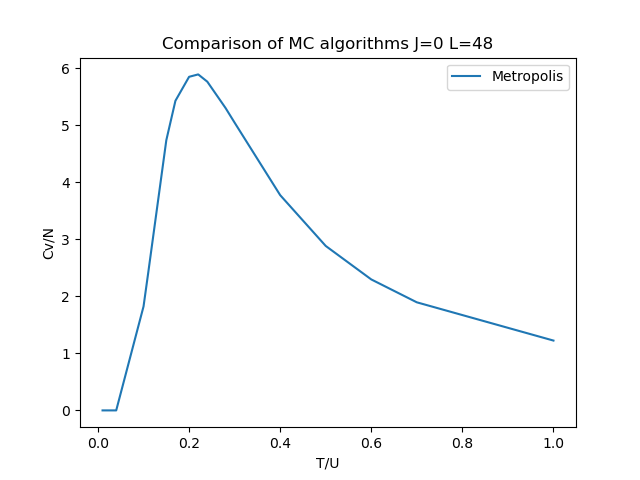

In [5]:
skip=5
ts1, ds1 = get_all_cvs("data/vsweeps/0/*/energy.dat", skip=skip)

plt.close("all")
plt.figure()
plt.plot(ts1, ds1, label="Metropolis")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.legend()
plt.title("Comparison of MC algorithms J=0 L=48")

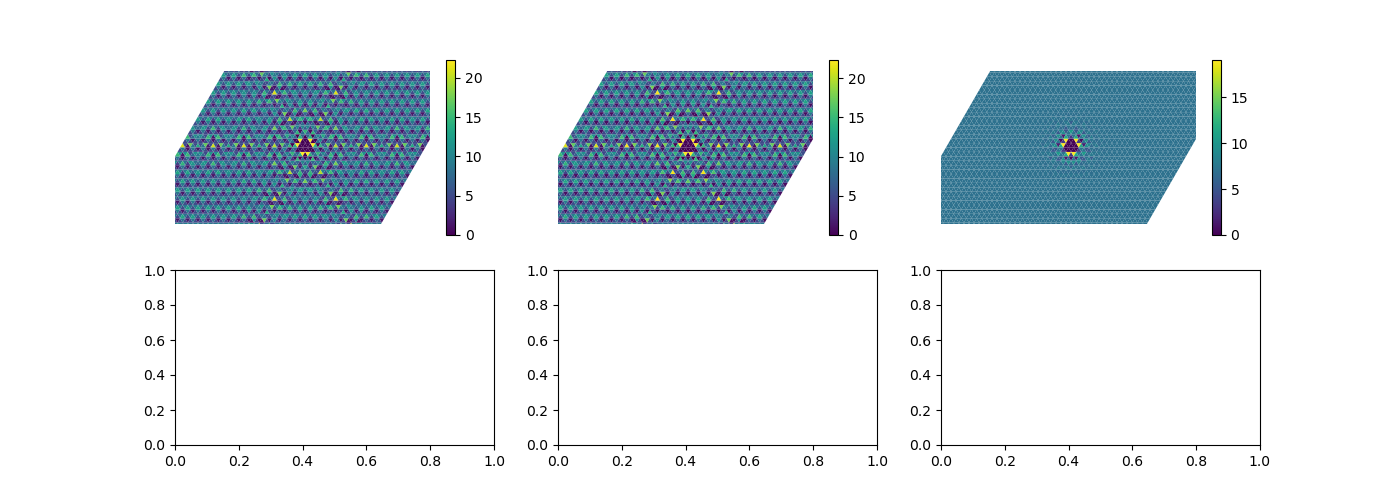

In [199]:
data1 = read_accumulator("data/vsweeps/v144/-0.1/48x48_r-144_t0.0050_j-0.1000_40000000.5_0/tri-tri.dat", skip=1)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/v144/-0.1/48x48_r-144_t0.0100_j-0.1000_40000000.5_0/tri-tri.dat", skip=1)[0].reshape((48, 48, 2))
data3 = read_accumulator("data/vsweeps/v144/-0.1/48x48_r-144_t0.1000_j-0.1000_40000000.5_0/tri-tri.dat", skip=1)[0].reshape((48, 48, 2))

fig, ax = plt.subplots(2, 3, figsize=[14, 5])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
# plot2d_hex(ax[1,0], data4)
# plot2d_hex(ax[1,1], data5)
# plot2d_hex(ax[1,2], data6)

## old

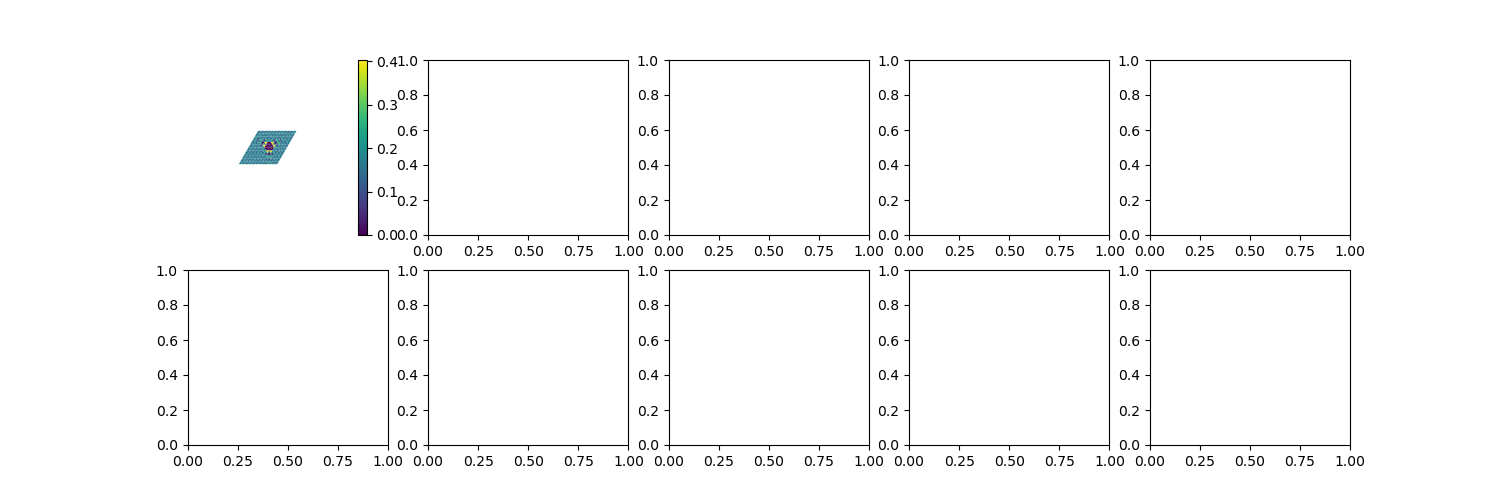

In [5]:
data1 = read_accumulator("data/temp/12x12_r-3_t0.000000_j0.000_100000.100_0/tri-tri.dat", skip=10)[0].reshape((12, 12, 2))
fig, ax = plt.subplots(2, 5, figsize=[15, 5])
plot2d_hex(ax[0,0], data1)

In [ ]:
data1 = read_accumulator("data/FT/48x48_r-3_uinf_4j0.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data2 = read_accumulator("data/FT/48x48_r-3_uinf_4j-1.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data3 = read_accumulator("data/FT/48x48_r-3_uinf_4j-2.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data4 = read_accumulator("data/FT/48x48_r-3_uinf_4j-3.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data5 = read_accumulator("data/FT/48x48_r-3_uinf_4j-4.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=[15, 5])
plot2d(ax[0,0], data1)
plot2d(ax[0,1], data2)
plot2d(ax[0,2], data3)
plot2d(ax[0,3], data4)
plot2d(ax[0,4], data5)
ax[0,0].set_title("0")
ax[0,1].set_title("-1")
ax[0,2].set_title("-2")
ax[0,3].set_title("-3")
ax[0,4].set_title("-4")

In [ ]:
data1 = read_accumulator("data/FT/48x48_r-3_uinf_4j0.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data2 = read_accumulator("data/FT/48x48_r-3_uinf_4j1.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data3 = read_accumulator("data/FT/48x48_r-3_uinf_4j2.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))
data4 = read_accumulator("data/FT/48x48_r-3_uinf_4j3.00_10000000.5_0/mono-mono.dat", skip=500)[0].reshape((48, 48))

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 5])
plot2d(ax[0,0], np.log(data1+1))
plot2d(ax[0,1], np.log(data2+1))
plot2d(ax[0,2], np.log(data3+1))
plot2d(ax[0,3], np.log(data4+1))
ax[0,0].set_title("0")
ax[0,1].set_title("1")
ax[0,2].set_title("2")
ax[0,3].set_title("3")

scratch

In [ ]:
data1 = read_accumulator("data/", skip=10)[0].reshape((96, 96, 2))

Text(0.5, 1.0, 'T=0.07')

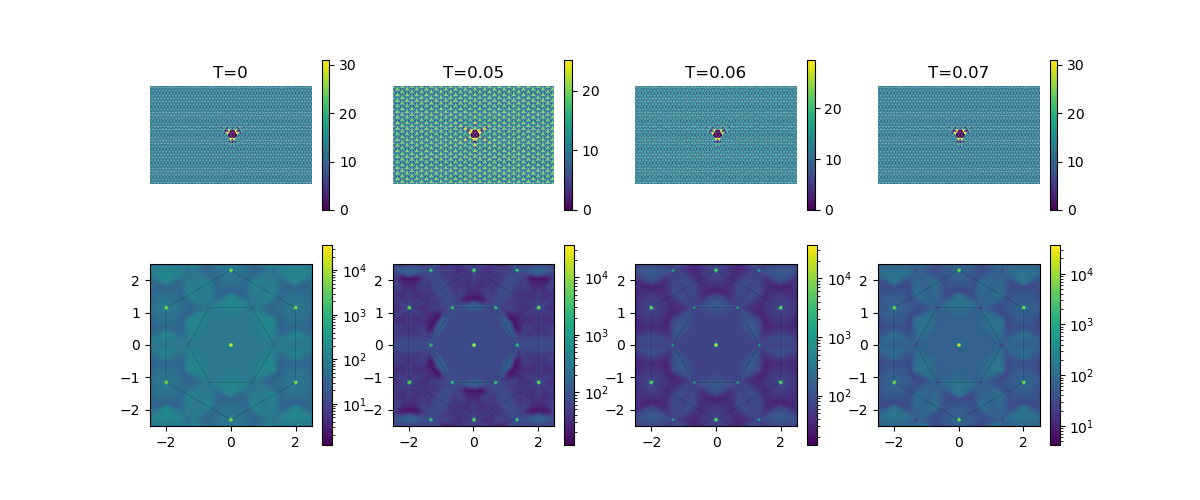

In [3]:
data1 = read_accumulator("data/obd/72x72_r-0_t0.000000_j0.000_1000000.5_0/tri-tri.dat", skip=10)[0].reshape((72, 72, 2))
data2 = read_accumulator("data/obd/72x72_r-0_t0.050000_j0.000_1000000.5_1/tri-tri.dat", skip=100)[0].reshape((72, 72, 2))
data3 = read_accumulator("data/obd/72x72_r-0_t0.060000_j0.000_1000000.5_0/tri-tri.dat", skip=50)[0].reshape((72, 72, 2))
data4 = read_accumulator("data/obd/72x72_r-0_t0.070000_j0.000_1000000.5_0/tri-tri.dat", skip=50)[0].reshape((72, 72, 2))
fig, ax = plt.subplots(2, 4, figsize=[12, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
plot_FT(ax[1,2], FT_hex(data3), proj="logabs")
plot_FT(ax[1,3], FT_hex(data4), proj="logabs")
ax[0,0].set_title("T=0")
ax[0,1].set_title("T=0.05")
ax[0,2].set_title("T=0.06")
ax[0,3].set_title("T=0.07")

Text(0.5, 1.0, 'T=0.07')

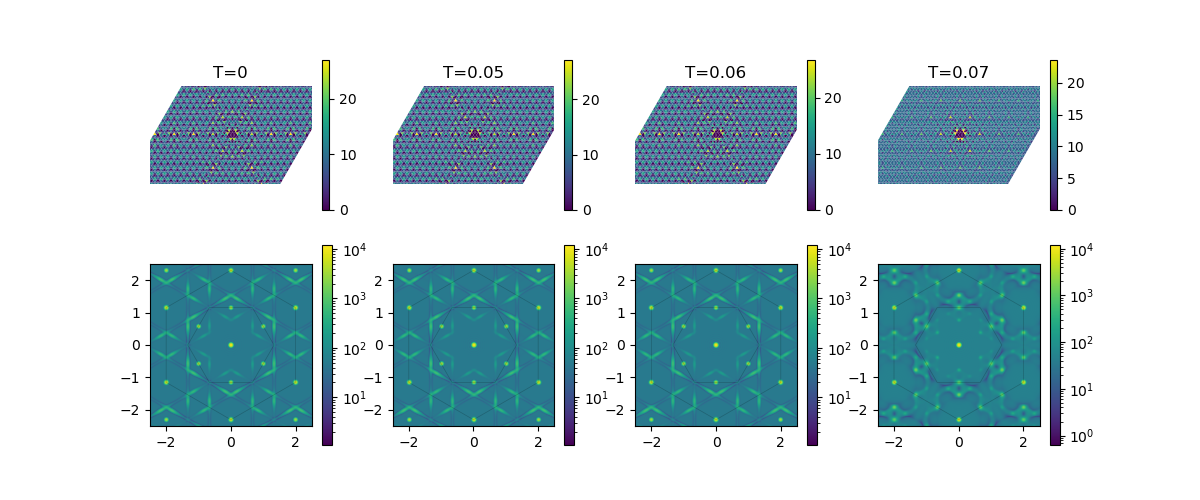

In [4]:
data1 = read_accumulator("data/vsweeps/-0.3/48x48_r-0_t0.0200_j-0.3000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/-0.3/48x48_r-0_t0.0600_j-0.3000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data3 = read_accumulator("data/vsweeps/-0.3/48x48_r-0_t0.0800_j-0.3000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data4 = read_accumulator("data/vsweeps/-0.3/48x48_r-0_t0.1000_j-0.3000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 4, figsize=[12, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
plot_FT(ax[1,2], FT_hex(data3), proj="logabs")
plot_FT(ax[1,3], FT_hex(data4), proj="logabs")
ax[0,0].set_title("T=0")
ax[0,1].set_title("T=0.05")
ax[0,2].set_title("T=0.06")
ax[0,3].set_title("T=0.07")

Text(0.5, 1.0, 'T=0.07')

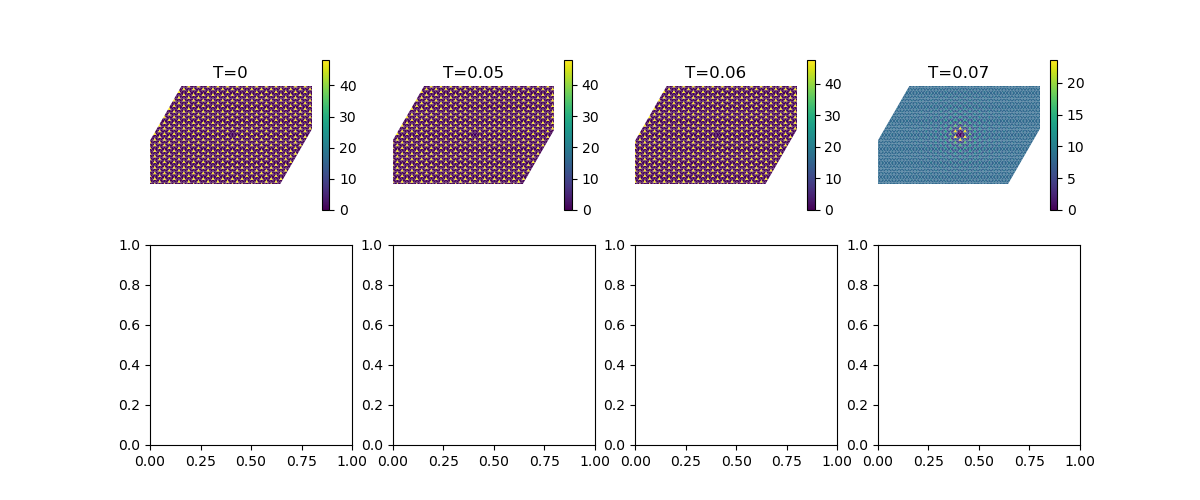

In [63]:
data1 = read_accumulator("data/vsweeps/0.2/48x48_r-0_t0.0200_j0.2000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/0.2/48x48_r-0_t0.1000_j0.2000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data3 = read_accumulator("data/vsweeps/0.2/48x48_r-0_t0.2000_j0.2000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data4 = read_accumulator("data/vsweeps/0.2/48x48_r-0_t0.2500_j0.2000_40000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 4, figsize=[12, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)
# plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
# plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
# plot_FT(ax[1,2], FT_hex(data3), proj="logabs")
# plot_FT(ax[1,3], FT_hex(data4), proj="logabs")
ax[0,0].set_title("T=0")
ax[0,1].set_title("T=0.05")
ax[0,2].set_title("T=0.06")
ax[0,3].set_title("T=0.07")

In [41]:
data1 = read_accumulator("data/rt3trans/36x36_r-3_uinf_4j0.30_20000000.5_0/mono-di.dat", skip=1000)[0].reshape((36, 36))

data2 = read_accumulator("data/bwtrans/36x36_r-3_uinf_4j-1.00_40000000.5_0/mono-mono.dat", skip=1000)[0].reshape((36, 36))
data3 = read_accumulator("data/rt3trans/36x36_r-3_uinf_4j0.00_20000000.5_0/mono-mono.dat", skip=1000)[0].reshape((36, 36))
data4 = read_accumulator("data/rt3trans/36x36_r-3_uinf_4j0.50_20000000.5_0/mono-mono.dat", skip=1000)[0].reshape((36, 36))

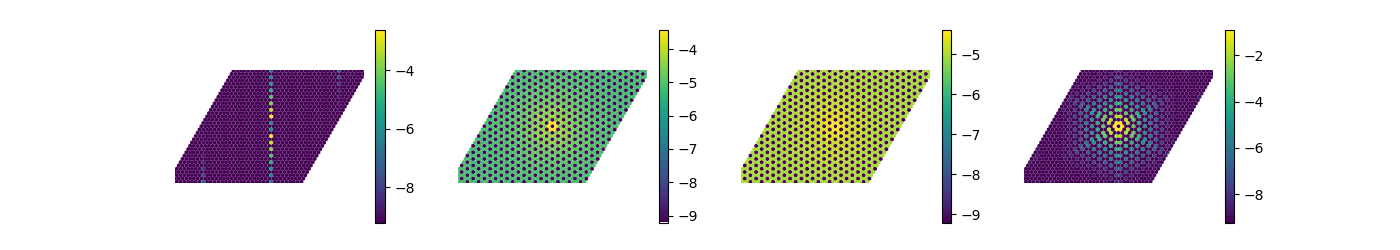

In [43]:
fig, ax = plt.subplots(1, 4, figsize=[14, 2.5])
plot2d(ax[0], np.log(data1.T+0.0001))
plot2d(ax[1], np.log(data2+0.0001))
plot2d(ax[2], np.log(data3+0.0001))
plot2d(ax[3], np.log(data4+0.0001))

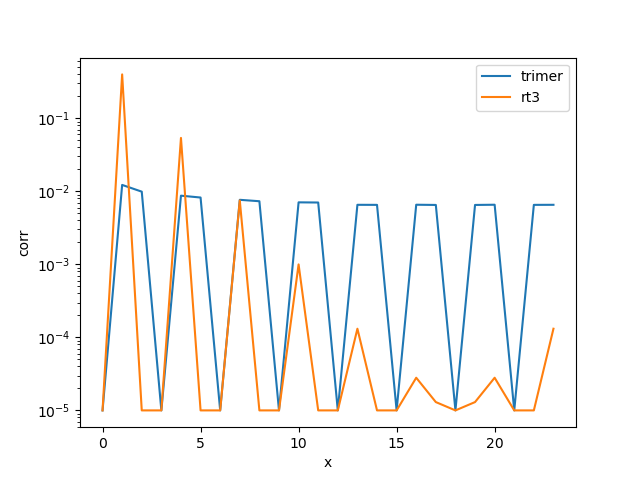

In [39]:
plt.figure()
plt.plot(data3[0, :24]+0.00001, label="trimer")
plt.plot(data4[0, :24]+0.00001, label="rt3")
plt.yscale("log")
plt.xlabel("x")
plt.ylabel("corr")
plt.legend()

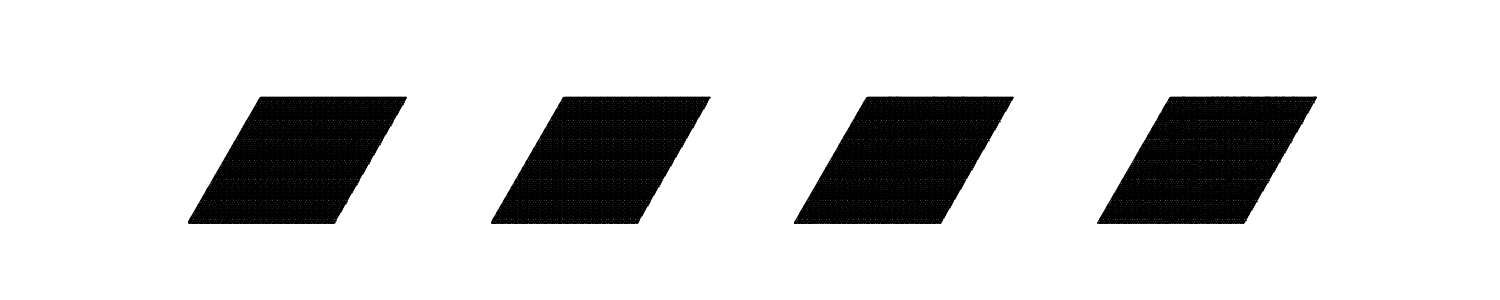

In [12]:
pocket.width = 60
pocket.height = 60
fig, ax = plt.subplots(1, 4, figsize=[15, 3])
pocket.draw_hexalattice(ax[0])
pocket.show_tiling(ax[0], (pos1, None), wf="tri")
pocket.draw_hexalattice(ax[1])
pocket.show_tiling(ax[1], (pos2, None), wf="tri")
pocket.draw_hexalattice(ax[2])
pocket.show_tiling(ax[2], (pos3, None), wf="tri")
pocket.draw_hexalattice(ax[3])
pocket.show_tiling(ax[3], (pos4, None), wf="tri")

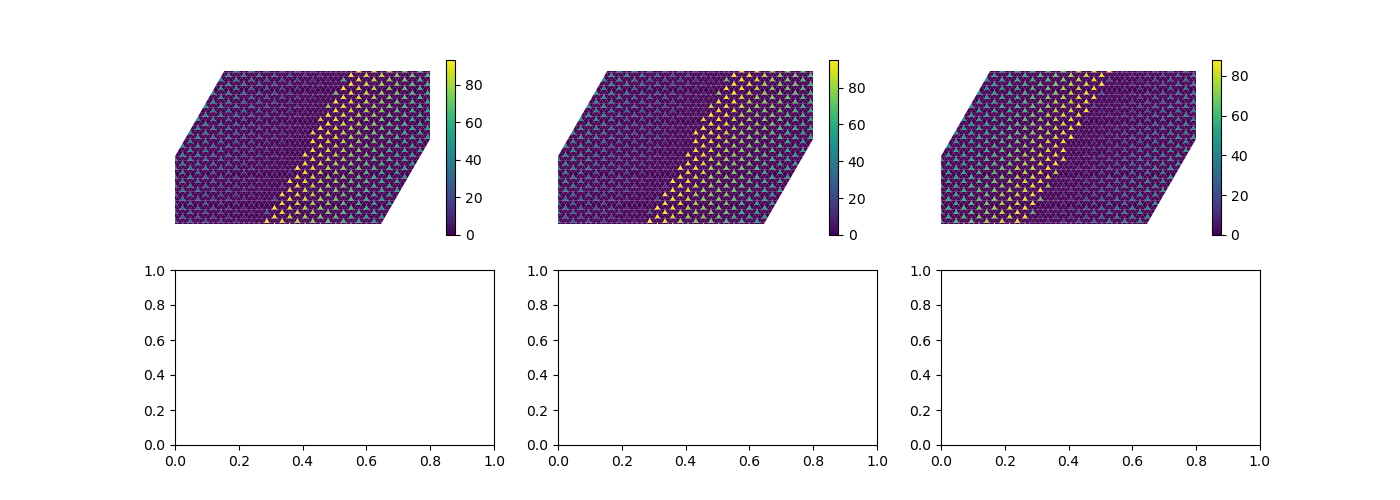

In [127]:
data1 = read_accumulator("data/temp/48x48_r-0_t0.100000_j0.000_100000.100_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data1 = read_accumulator("data/temp/48x48_r-0_t0.100000_j0.000_100000.100_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))

fig, ax = plt.subplots(2, 3, figsize=[14, 5])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)

### bw

In [ ]:
js1 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5])
ds1 = np.array([read_accumulator(f"data/bwtrans/24x24_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js1])
js2 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7])
ds2 = np.array([read_accumulator(f"data/bwtrans/36x36_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js2])
js3 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7])
ds3 = np.array([read_accumulator(f"data/bwtrans/48x48_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js3])
js4 = np.array([-0.5, -1, -1.5, -1.7, -1.9, -2, -2.1, -2.3, -2.5, -3, -3.5, -4, -5, -6, -7])
ds4 = np.array([read_accumulator(f"data/bwtrans/60x60_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js4])

In [ ]:
plt.figure()
plt.plot(js1, ds1*ds1*js1*js1/24/24*3, label="24")
plt.plot(js2, ds2*ds2*js2*js2/36/36*3, label="36")
plt.plot(js3, ds3*ds3*js3*js3/48/48*3, label="48")
plt.plot(js4, ds4*ds4*js4*js4/60/60*3, label="60")
plt.legend()
plt.xlabel("J4/T")
plt.ylabel("Cv/N")

In [ ]:
js1 = np.array([-2, -2.2, -2.4, -2.6, -2.8, -3, -3.2, -3.4, -3.6, -3.8, -4])
ds1 = np.array([read_accumulator(f"data/bwtrans2/12x12_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js1])
js2 = np.array([-2, -2.2, -2.4, -2.6, -2.8, -3, -3.2, -3.4, -3.6, -3.8, -4])
ds2 = np.array([read_accumulator(f"data/bwtrans2/24x24_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js2])
js3 = np.array([-2, -2.2, -2.4, -2.6, -2.8, -3, -3.2, -3.4, -3.6, -3.8, -4])
ds3 = np.array([read_accumulator(f"data/bwtrans2/36x36_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js3])
js4 = np.array([-2, -2.2, -2.4, -2.6, -2.8, -3, -3.2, -3.4, -3.6, -3.8, -4])
ds4 = np.array([read_accumulator(f"data/bwtrans2/48x48_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js4])
js5 = np.array([-2, -2.2, -2.4, -2.6, -2.8, -3, -3.2, -3.4, -3.6, -3.8, -4])
ds5 = np.array([read_accumulator(f"data/bwtrans2/60x60_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=100)[1][1] for x in js5])

In [ ]:
plt.figure()
plt.plot(js1, ds1*ds1*js1*js1/12/12*3, label="12")
plt.plot(js2, ds2*ds2*js2*js2/24/24*3, label="24")
plt.plot(js3, ds3*ds3*js3*js3/36/36*3, label="36")
plt.plot(js4, ds4*ds4*js4*js4/48/48*3, label="48")
plt.plot(js5, ds5*ds5*js5*js5/60/60*3, label="60")
plt.legend()
plt.xlabel("J4/T")
plt.ylabel("Cv/N")

In [ ]:
plt.figure()
plt.plot(read_accumulator_raw(f"data/bwtrans2/60x60_r-3_uinf_4j-3.40_40000000.5_0/energy.dat")[1][:, 1])
plt.title("L=60 J4=-3.4")
plt.xlabel("MC sweep # (*25000)")
plt.ylabel("# j4 bonds")

In [ ]:
data1 = read_accumulator("data/bwtrans2/12x12_r-3_uinf_4j-2.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((12, 12, 2))
data2 = read_accumulator("data/bwtrans2/24x24_r-3_uinf_4j-2.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((24, 24, 2))
data3 = read_accumulator("data/bwtrans2/48x48_r-3_uinf_4j-2.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((48, 48, 2))
data4 = read_accumulator("data/bwtrans2/12x12_r-3_uinf_4j-4.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((12, 12, 2))
data5 = read_accumulator("data/bwtrans2/24x24_r-3_uinf_4j-4.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((24, 24, 2))
data6 = read_accumulator("data/bwtrans2/48x48_r-3_uinf_4j-4.00_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((48, 48, 2))

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[1,0], data4)
plot2d_hex(ax[1,1], data5)
plot2d_hex(ax[1,2], data6)

In [ ]:
data1 = read_accumulator("data/temp/12x12_r-3_uinf_4j-999.0000_10000.1_0/tri-tri.dat", skip=1000)[0].reshape((12, 12, 2))
data2 = read_accumulator("data/temp/12x12_r-3_uinf_4j-10.0000_10000.1_0/tri-tri.dat", skip=1000)[0].reshape((12, 12, 2))
data3 = read_accumulator("data/temp/12x12_r-3_uinf_4j-4.0000_10000.1_3/tri-tri.dat", skip=1000)[0].reshape((12, 12, 2))
data4 = read_accumulator("data/temp/12x12_r-3_uinf_4j-2.0000_10000.1_0/tri-tri.dat", skip=1000)[0].reshape((12, 12, 2))

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[0,3], data4)

In [ ]:
js = np.array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.4, 0.5])
ds1 = np.array([read_accumulator(f"data/rt3trans/24x24_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=300)[1][1] for x in js])
ds2 = np.array([read_accumulator(f"data/rt3trans/36x36_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=300)[1][1] for x in js])
ds3 = np.array([read_accumulator(f"data/rt3trans/48x48_r-3_uinf_4j{x:.2f}_20000000.5_0/energy.dat", skip=300)[1][1] for x in js])

In [ ]:
plt.figure()
plt.plot(js, ds1*ds1*js*js/24/24*3)
plt.plot(js, ds2*ds3*js*js/36/36*3)
plt.plot(js, ds3*ds3*js*js/48/48*3)
plt.xlabel("T/J4")
plt.ylabel("Cv/N")

### rt3

In [ ]:
js1 = np.array([0.05, 0.1, 0.15, 0.17, 0.20, 0.23, 0.25, 0.27, 0.3, 0.4])
ds1 = np.array([read_accumulator(f"data/rt3trans2/12x12_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=200)[1][1] for x in js1])
js2 = np.array([0.1, 0.15, 0.17, 0.19, 0.2, 0.21, 0.23, 0.25, 0.3])
ds2 = np.array([read_accumulator(f"data/rt3trans2/24x24_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=200)[1][1] for x in js2])
js3 = np.array([0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.25])
ds3 = np.array([read_accumulator(f"data/rt3trans2/36x36_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=200)[1][1] for x in js3])
js4 = np.array([0.05, 0.07, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.17, 0.20, 0.25])
ds4 = np.array([read_accumulator(f"data/rt3trans2/48x48_r-3_uinf_4j{x:.2f}_40000000.5_0/energy.dat", skip=200)[1][1] for x in js4])
js5 = np.array([0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.15])
ds5 = np.array([read_accumulator(f"data/rt3trans2/60x60_r-3_uinf_4j{x:.4f}_40000000.5_0/energy.dat", skip=200)[1][1] for x in js5])

In [ ]:
plt.figure()
plt.plot(js1, ds1*ds1*js1*js1/12/12*3, label="L=12")
plt.plot(js2, ds2*ds2*js2*js2/48/24*3, label="L=24")
plt.plot(js3, ds3*ds3*js3*js3/36/36*3, label="L=36")
plt.plot(js4, ds4*ds4*js4*js4/48/48*3, label="L=48")
plt.plot(js5, ds5*ds5*js5*js5/60/60*3, label="L=60")
plt.xlabel("T/J4")
plt.ylabel("Cv/N")
plt.legend()

In [ ]:
np.sqrt(data[2][:, 1]/data[0])

In [ ]:
plt.figure()

# data = read_accumulator_raw(f"data/rt3trans2/60x60_r-3_uinf_4j0.0900_40000000.5_0/energy.dat")
# plot_timeseries(data[1][:, 1], data[2][:, 1], label="J4=0.09")
# data = read_accumulator_raw(f"data/rt3trans2/60x60_r-3_uinf_4j0.1000_40000000.5_0/energy.dat")
# plot_timeseries(data[1][:, 1], data[2][:, 1], label="J4=0.10")

data = read_accumulator_raw(f"data/rt3trans2/12x12_r-3_uinf_4j0.20_40000000.5_0/energy.dat")
plot_timeseries(data[1][:, 1], data[2][:, 1], label="J4=0.20")
data = read_accumulator_raw(f"data/rt3trans2/12x12_r-3_uinf_4j0.30_40000000.5_0/energy.dat")
plot_timeseries(data[1][:, 1], data[2][:, 1], label="J4=0.30")
data = read_accumulator_raw(f"data/rt3trans2/12x12_r-3_uinf_4j0.40_40000000.5_0/energy.dat")
plot_timeseries(data[1][:, 1], data[2][:, 1], label="J4=0.40")

plt.title("L=12")
plt.xlabel("MC sweep # (*25000)")
plt.ylabel("# j4 bonds")
plt.legend()

In [ ]:
data1 = read_accumulator("data/rt3trans2/12x12_r-3_uinf_4j0.25_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((12, 12, 2))
data2 = read_accumulator("data/rt3trans2/12x12_r-3_uinf_4j0.40_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((12, 12, 2))
data3 = read_accumulator("data/rt3trans2/24x24_r-3_uinf_4j0.20_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((24, 24, 2))
data4 = read_accumulator("data/rt3trans2/24x24_r-3_uinf_4j0.25_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((24, 24, 2))
data5 = read_accumulator("data/rt3trans2/36x36_r-3_uinf_4j0.15_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((36, 36, 2))
data6 = read_accumulator("data/rt3trans2/36x36_r-3_uinf_4j0.17_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((36, 36, 2))
data7 = read_accumulator("data/rt3trans2/48x48_r-3_uinf_4j0.10_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((48, 48, 2))
data8 = read_accumulator("data/rt3trans2/48x48_r-3_uinf_4j0.15_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((48, 48, 2))
data9 = read_accumulator("data/rt3trans2/60x60_r-3_uinf_4j0.0600_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((60, 60, 2))

In [ ]:
data10 = read_accumulator("data/rt3trans2/60x60_r-3_uinf_4j0.1000_40000000.5_0/tri-tri.dat", skip=100)[0].reshape((60, 60, 2))

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[1,0], data2)
plot2d_hex(ax[0,1], data3)
plot2d_hex(ax[1,1], data4)
plot2d_hex(ax[0,2], data5)
plot2d_hex(ax[1,2], data6)
plot2d_hex(ax[0,3], data7)
plot2d_hex(ax[1,3], data8)
plot2d_hex(ax[0,4], data9)
plot2d_hex(ax[1,4], data10)

### u

In [ ]:
js = np.array([0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 10])
ds0 = np.array([read_accumulator(f"data/FT/6x6_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds1 = np.array([read_accumulator(f"data/FT/12x12_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds2 = np.array([read_accumulator(f"data/FT/24x24_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds3 = np.array([read_accumulator(f"data/FT/36x36_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])
ds4 = np.array([read_accumulator(f"data/FT/48x48_r-3_u{x:.2f}_4j0.00_10000000.5_0/energy.dat")[1][0] for x in js])

In [ ]:
plt.close("all")
plt.figure()
plt.plot(js, ds0*ds0*js*js/6/6*3, label="L=6")
plt.plot(js, ds1*ds1*js*js/12/12*3, label="L=12")
plt.plot(js, ds2*ds2*js*js/24/24*3, label="L=24")
plt.plot(js, ds3*ds3*js*js/36/36*3, label="L=36")
plt.plot(js, ds4*ds4*js*js/48/48*3, label="L=48")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.xlim([0, 2])
plt.legend()

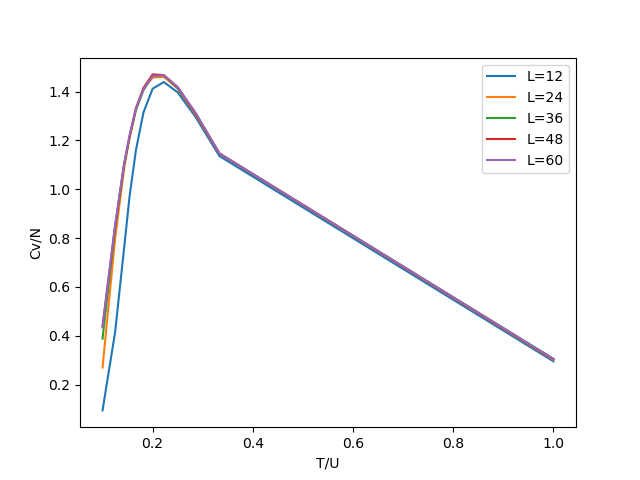

In [7]:
js0 = np.array([1, 2, 2.5, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 8])
ds0 = np.array([read_accumulator(f"data/utrans/6x6_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js0])
js1 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds1 = np.array([read_accumulator(f"data/utrans/12x12_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js1])
js2 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds2 = np.array([read_accumulator(f"data/utrans/24x24_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js2])
js3 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds3 = np.array([read_accumulator(f"data/utrans/36x36_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js3])
js4 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds4 = np.array([read_accumulator(f"data/utrans/48x48_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js4])
js5 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds5 = np.array([read_accumulator(f"data/utrans/60x60_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js5])

plt.close("all")
plt.figure()
# plt.plot(1/js0, ds0*ds0*js0*js0/6/6*3/4, label="L=6")
plt.plot(1/js1, ds1*ds1*js1*js1/12/12*3/4, label="L=12")
plt.plot(1/js2, ds2*ds2*js2*js2/24/24*3/4, label="L=24")
plt.plot(1/js3, ds3*ds3*js3*js3/36/36*3/4, label="L=36")
plt.plot(1/js4, ds4*ds4*js4*js4/48/48*3/4, label="L=48")
plt.plot(1/js5, ds5*ds5*js5*js5/60/60*3/4, label="L=60")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt
plt.legend()

In [ ]:
js1 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds1 = np.array([read_accumulator(f"data/utrans/60x60_r-3_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js1])
js2 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds2 = np.array([read_accumulator(f"data/utrans/60x60_r-0_u{x:.4f}_4j0.0000_40000000.5_0/energy.dat")[1][0] for x in js2])

plt.close("all")
plt.figure()
plt.plot(js1, ds1*ds1*js1*js1/60/60*3, label="L=60 v=-1")
plt.plot(js2, ds2*ds2*js2*js2/60/60*3, label="L=60 v=0")
plt.ylabel("Cv/N")
plt.xlabel("T/U")
plt.legend()

In [ ]:
data1 = read_accumulator("data/FT/24x24_r-3_u2.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((24, 24, 2))
data2 = read_accumulator("data/FT/24x24_r-3_u5.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((24, 24, 2))
data3 = read_accumulator("data/FT/24x24_r-3_u8.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((24, 24, 2))

data4 = read_accumulator("data/FT/48x48_r-3_u2.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data5 = read_accumulator("data/FT/48x48_r-3_u5.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))
data6 = read_accumulator("data/FT/48x48_r-3_u8.00_4j0.00_10000000.5_0/tri-tri.dat", skip=10)[0].reshape((48, 48, 2))

fig, ax = plt.subplots(2, 3, figsize=[15, 6])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot2d_hex(ax[0,2], data3)
plot2d_hex(ax[1,0], data4)
plot2d_hex(ax[1,1], data5)
plot2d_hex(ax[1,2], data6)

In [ ]:
c = 1
js0 = np.array([1, 2, 2.5, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 6, 8])
ds0 = np.array([read_accumulator(f"data/utrans/6x6_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js0])
js1 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds1 = np.array([read_accumulator(f"data/utrans/12x12_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js1])
js2 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds2 = np.array([read_accumulator(f"data/utrans/24x24_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js2])
js3 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds3 = np.array([read_accumulator(f"data/utrans/36x36_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js3])
js4 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds4 = np.array([read_accumulator(f"data/utrans/48x48_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js4])
js5 = np.array([1, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 8, 10])
ds5 = np.array([read_accumulator(f"data/utrans/60x60_r-3_u{x:.4f}_4j0.0000_40000000.5_0/cluster-count.dat")[0][c] for x in js5])

plt.close("all")
plt.figure()
plt.plot(1/js0, ds0/6/6, label="L=6")
plt.plot(1/js1, ds1/12/12, label="L=12")
plt.plot(1/js2, ds2/24/24, label="L=24")
plt.plot(1/js3, ds3/36/36, label="L=36")
plt.plot(1/js4, ds4/48/48, label="L=48")
plt.plot(1/js5, ds5/60/60, label="L=60")
plt.ylabel("cluster 1 density")
plt.xlabel("T/U")
plt.legend()

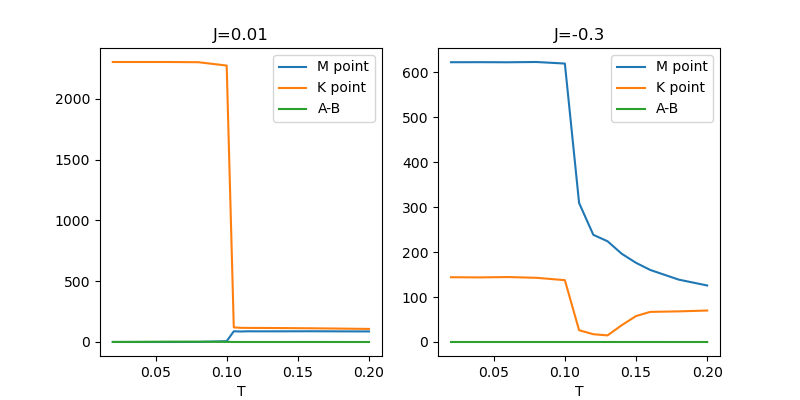

In [2]:
ts, ds = get_all_data("data/rt3order/48*/order.dat", lambda x, props: x[0], skip=100)
fig, ax = plt.subplots(1, 2, figsize=[8, 4])
ax[0].plot(ts, ds[:, 0], label="M point")
ax[0].plot(ts, ds[:, 3], label="K point")
ax[0].plot(ts, ds[:, 6], label="A-B")
ax[0].set_xlabel("T")
ax[0].set_title("J=0.01")
ax[0].legend()
ts, ds = get_all_data("data/bworder/48*/order.dat", lambda x, props: x[0], skip=100)
ax[1].plot(ts, ds[:, 0], label="M point")
ax[1].plot(ts, ds[:, 3], label="K point")
ax[1].plot(ts, ds[:, 6], label="A-B")
ax[1].set_xlabel("T")
ax[1].set_title("J=-0.3")
ax[1].legend()


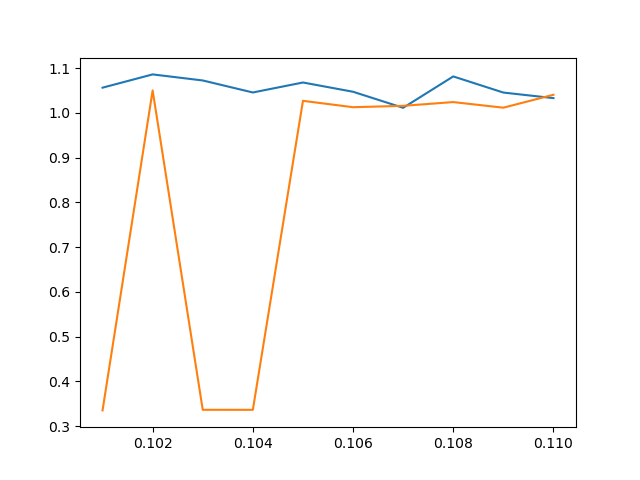

In [3]:
plt.figure()
ts, ds = get_all_data("data/rt3order2/48*/order.dat", lambda x, props: x[0], skip=100)
plt.plot(ts, ds[:, 8]/3/ds[:, 7]**2, label="A-B")
ts, ds = get_all_data("data/rt3order2/60*/order.dat", lambda x, props: x[0], skip=100)
plt.plot(ts, ds[:, 8]/3/ds[:, 7]**2, label="A-B")